# Análise de Séries Temporais: Dados Ibovespa
## Pós Graduação em Data Analytics - FIAP
### Aluna: Jessica Brito Moura

## Importação de Bibliotecas

In [106]:
# Para exploração e análise de dados
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import time

# Análises estatísticas
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Modelos
from statsforecast import StatsForecast
from statsforecast.models import HoltWinters
from prophet import Prophet
import statsmodels.api as statsmodelapi

# Métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error,r2_score

In [107]:
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

Definição de variáveis para os aspectos visuais dos gráficos neste notebook.

In [108]:
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)

from pylab import rcParams
rcParams['figure.figsize'] = (18,7)

## Sobre nossos Dados

"O Ibovespa é o principal indicador de desempenho das ações negociadas na B3 e reúne as empresas mais importantes do mercado de capitais brasileiro. Foi criado em 1968 e, ao longo desses 50 anos, consolidou-se como referência para investidores ao redor do mundo.

Reavaliado a cada quatro meses, o índice é resultado de uma carteira teórica de ativos. É composto pelas ações e units de companhias listadas na B3 que atendem aos critérios descritos na sua metodologia, correspondendo a cerca de 80% do número de negócios e do volume financeiro do nosso mercado de capitais." 

Fonte: __[Ibovespa](https://www.b3.com.br/pt_br/market-data-e-indices/indices/indices-amplos/ibovespa.htm)__

## Objetivo

O objetivo deste presente trabalho é realizar um modelo preditivo com dados da IBOVESPA (Bolsa de Valores) para criar uma série temporal e prever diariamente o fechamento da base.

## 1. Análise Exploratória de Dados

Começamos a etapa de análise exploratória com a importação da base de dados e seus primeiros tratamentos. Nossa base de dados, contida na pasta **bases** trata-se do histórico de cotação, durante o período de 10 anos (2014 - 2024) da Ibovespa.

Pegamos apenas as três primeiras colunas da tabela: `Data`, `Último` e `Abertura`. A coluna Data é tratada pela função **parse_dates**, que a transforma para o tipo datetime no momento que a tabela é carregada.

In [109]:
ibovespa_dataframe = pd.read_csv("bases/History_Ibovespa_2014-2024.csv",
                                    usecols=[0,1,2],
                                    sep=',',
                                    parse_dates=['Data']
                                    )

/tmp/ipykernel_2444/1597323562.py:1: UserWarning:

Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



A função `head()` nos mostra as primeiras cinco linhas do dataframe e nos fornece um visual resumido de como a base é estruturada.

In [110]:
ibovespa_dataframe.head()

,Data,Último,Abertura
0,2024-06-28,123.907,124.308
1,2024-06-27,124.308,122.642
2,2024-06-26,122.641,122.331
3,2024-06-25,122.331,122.634
4,2024-06-24,122.637,121.343


O uso de `info()` é útil para indicar o tipo das colunas e se há existência de valores nulos na base. O mais importante nessa etapa é se certificar de não há valores nulos em nenhuma das colunas e que a coluna de data está devidamente identificada com o tipo datetime.

In [111]:
ibovespa_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      2600 non-null   datetime64[ns]
 1   Último    2600 non-null   float64       
 2   Abertura  2600 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 61.1 KB


O tratamento feito a seguir é específico para os modelos de previsão. A grande maioria dos modelos de previsão de séries temporais espera o seguinte padrão:

- `y`: coluna com os valores reais, os quais se desejam alcançar
- `ds`: coluna com o tempo
- `unique_id`: id de identificação dos valores reais

Também ordenamos os valores da data mais antiga para a mais recente!

In [112]:
ibovespa_dataframe["unique_id"]="close"
ibovespa_dataframe.columns=["ds","y","open","unique_id"]
ibovespa_dataframe.sort_values('ds',inplace=True)
ibovespa_dataframe.reset_index(inplace=True)
ibovespa_dataframe.drop('index',axis=1,inplace=True)
ibovespa_dataframe.head()

,ds,y,open,unique_id
0,2014-01-02,50.341,51.522,close
1,2014-01-03,50.981,50.348,close
2,2014-01-06,50.974,50.980,close
3,2014-01-07,50.430,50.982,close
4,2014-01-08,50.577,50.431,close


Com a função `describe()`, podemos ter uma visão geral estatística dos nossos dados. Também geramos um gráfico com a densidade dos valores de `y`.

count    2600.000000
mean       86.611760
std        27.350973
min        37.497000
25%        58.347500
50%        91.872000
75%       111.043500
max       134.194000
Name: y, dtype: float64

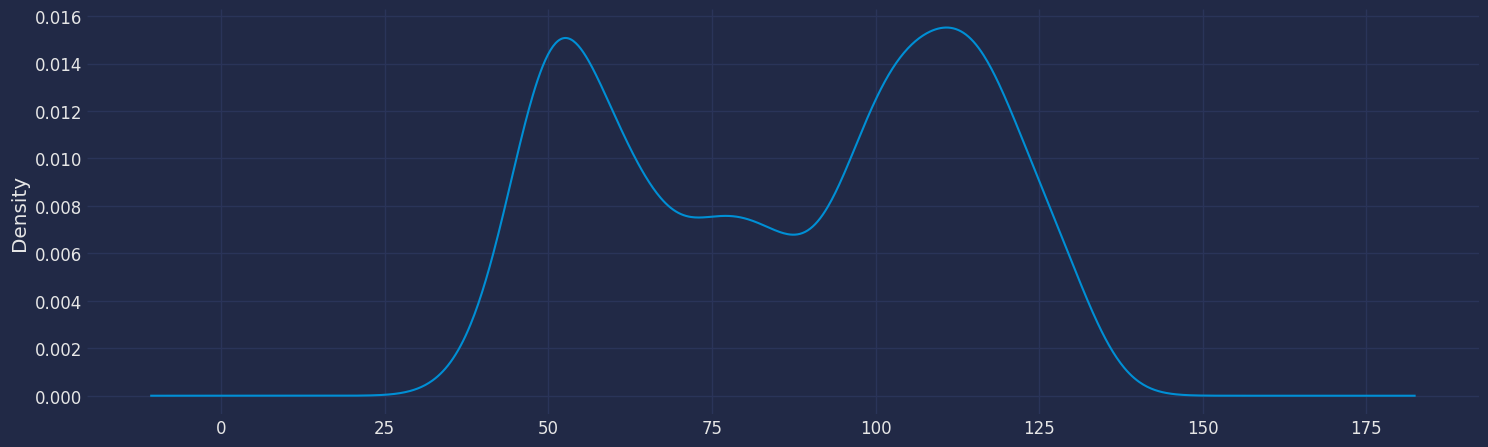

In [113]:
ibovespa_dataframe["y"].plot(kind='kde',figsize = (16,5))
ibovespa_dataframe["y"].describe()

#### Gráfico: Série Temporal

Observando o gráfico abaixo, podemos notar uma tendência crescendo com o decorrer do tempo. Em destaque, nota-se a queda drástica no ano de 2020, no qual se deu a pandemia do COVID-19; a pandemia afetou diretamente os valores das ações, não apenas no Brasil, e provocou suas quedas durante o ano inteiro. Decorrido esse espaço de tempo, os dados retomam o comportamento de crescimento.

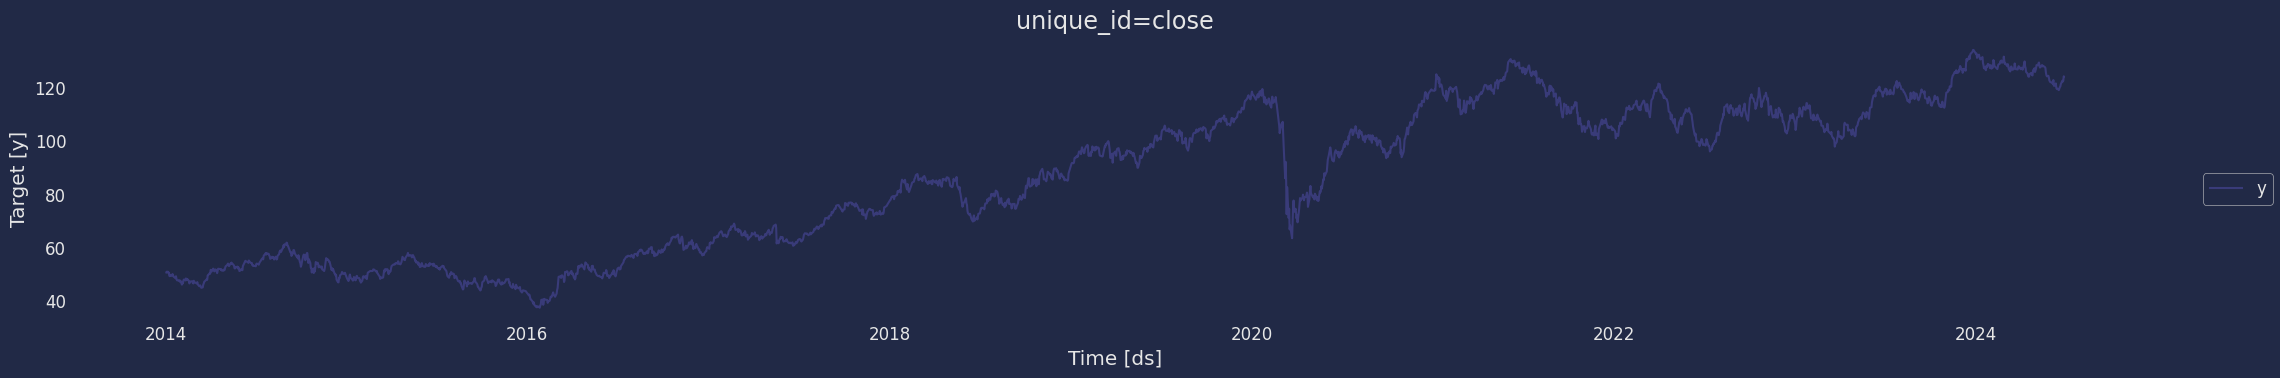

In [114]:
StatsForecast.plot(ibovespa_dataframe)

### 1.1. Decomposição dos dados

Para se conhecer novos valores em uma série temporal, é crucial conhecer os dados passados, entender quais padrões seguem ao longo do tempo; basicamente, uma série temporal é composta por quatro principais componentes:

1. `Nivel`: O valor principal que faz a média ao longo do tempo.
2. `Tendência`: Valor que causa padrões de aumento ou diminuição em uma série temporal.
3. `Sazonalidade`: Evento cíclico que ocorre por um curto período e provoca padrões de aumento ou diminuição de curto prazo na série temporal.
4. `Ruído/Resíduo`: Variações aleatórias na série temporal.

A maioria das séries temporais inclui nível e ruído/resíduo, enquanto tendência e sazonalidade são valores opcionais. Se a sazonalidade e a tendência fizerem parte da série temporal, haverá efeitos no valor previsto. Isso porque o padrão da série temporal prevista pode ser diferente da série temporal anterior.

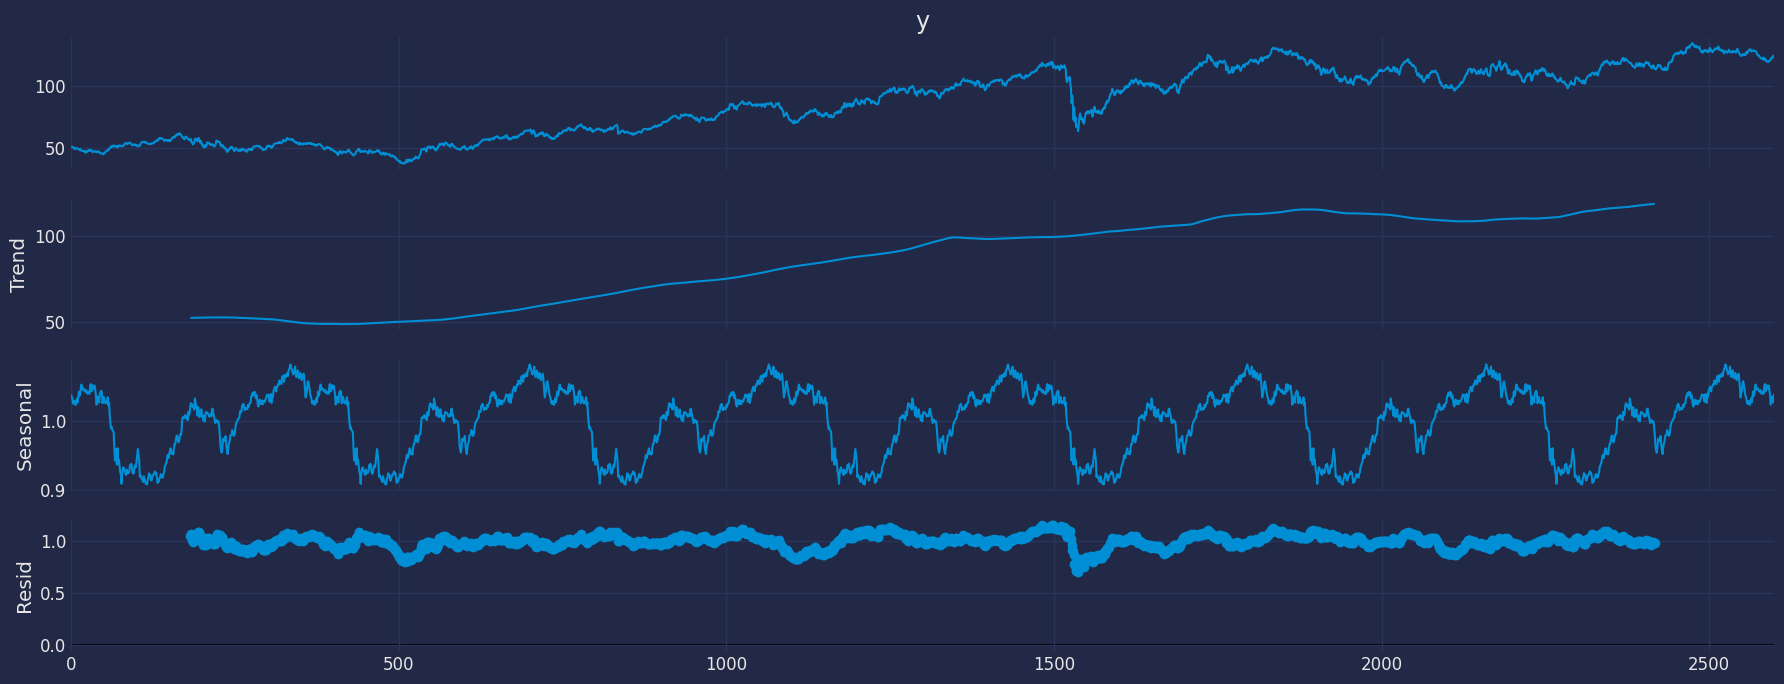

In [115]:
results = seasonal_decompose(ibovespa_dataframe["y"], model='multiplicative',period=365) # Optamos o período anual
fig = results.plot()

Podemos observar uma tendência (`trend`) crescente na nossa série, juntamente com um padrão de sazionalidade (`seasonal`) anual. Apenas pelo gráfico, podemos supor que a série não é estacionária. Entretanto, há testes que podemos fazer para confirmar ou não nossa teoria.

### 1.2. Estacionaridade

Estacionariedade significa que as características estatísticas de uma série temporal não mudam ao longo do tempo. Isso não quer dizer que a série não muda nunca, mas sim que a forma como ela muda é uma constante. Em termos de matemática, imagine que seja o seguinte: É uma função linear que se altera conforme X cresce. Mas ela tem uma inclinação que se mantém constante, porque a maneira como ela muda é constante. E por que isso é importante?

Processos estacionários são mais fáceis de analisar. Usando uma definição informal: uma vez que a maneira como mudam é previsível (constante), são processos mais previsíveis.

Fonte: __[Stationarity in time series analysis](https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322#:~:text=In%20the%20most%20intuitive%20sense,not%20itself%20change%20over%20time.)__

#### 1.2.1. Teste Augmented Dickey-Fuller (ADF)

Um teste de Dickey-Fuller aumentado (ADF) é um teste estatístico para verificar se uma série temporal tem uma "raiz unitária", que pode causar resultados imprevisíveis. O teste verifica se os dados seguem uma tendência com o tempo.

- **Hipótese nula**: A série temporal não é estacionária (depende do tempo).
- **Hipótese alternativa**: A série temporal é estacionária (não depende do tempo).


Se os valores do teste ADF forem menores que os valores críticos, rejeitamos a hipótese nula e concluímos que a série é estacionária. Se forem maiores, não rejeitamos a hipótese nula e a série não é estacionária.

In [116]:
def adf_test(timeseries, valor_critico):
    print ('------- Resultados do Teste ADF: -------')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Teste Estatístico','P-Value','#Lags Usados','Número de observações usadas'])
    
    for key,value in dftest[4].items():
        dfoutput['Valor Crítico (%s)'%key] = value
        
    if dftest[1] < valor_critico: # Hipótese Nula
        dfoutput['-> Estacionária'] = True
    else: # Hipótese Alternativa
        dfoutput['-> Estacionária'] = False
        
    print (dfoutput)

Realizando o teste pela primeira vez para o nivel de confiança de 95%:

In [117]:
adf_test(ibovespa_dataframe['y'], 0.05)

------- Resultados do Teste ADF: -------
Teste Estatístico              -1.223661
P-Value                         0.663336
#Lags Usados                         7.0
Número de observações usadas      2592.0
Valor Crítico (1%)             -3.432875
Valor Crítico (5%)             -2.862656
Valor Crítico (10%)            -2.567364
-> Estacionária                    False
dtype: object


Confirmamos aquilo que o gráfico já nos fazia suspeitar: a série *não é* Estacionária.

Sabendo dos resultados do teste ADF, podemos determinar o próximo passo. Nesse caso, em que o resultado foi de que a série temporal não é estacionária, podemos prosseguir para o passo de **diferenciar** a série temporal.

#### 1.2.2. Diferenciação

A diferenciação pode ajudar a estabilizar a média de uma série temporal ao remover mudanças no nível da série, eliminando (ou reduzindo) assim a tendência e a sazonalidade.

Fonte: __[Stationarity and differencing](https://otexts.com/fpp3/stationarity.html)__

Fazemos uma cópia da nossa base e usamos a função `.diff()` para realizar a diferenciação

In [118]:
df_diff=ibovespa_dataframe.copy()
df_diff['y_diff'] = df_diff['y'].diff()
df_diff.dropna(inplace=True)
df_diff.head()

,ds,y,open,unique_id,y_diff
1,2014-01-03,50.981,50.348,close,0.640
2,2014-01-06,50.974,50.980,close,-0.007
3,2014-01-07,50.430,50.982,close,-0.544
4,2014-01-08,50.577,50.431,close,0.147
5,2014-01-09,49.322,50.576,close,-1.255


E agora testamos essa nova base com o ADF:

In [119]:
adf_test(df_diff['y_diff'], 0.05)

------- Resultados do Teste ADF: -------
Teste Estatístico              -17.883538
P-Value                               0.0
#Lags Usados                          6.0
Número de observações usadas       2592.0
Valor Crítico (1%)              -3.432875
Valor Crítico (5%)              -2.862656
Valor Crítico (10%)             -2.567364
-> Estacionária                      True
dtype: object


A série se tornou estacionária!

Agora sabemos que uma diferenciação pode auxiliar na transformação da nossa série para modelos de previsão. Usaremos essa informação pouco mais à frente.

## 2. Treino e Teste

Separamos a base em treino e teste: os últimos vinte valores da base (que correspondem aproximadamente a um mês de dias úteis) são separados para a `base de teste`, enquanto o restante da base é separada para a `base de treino`. Uma terceira base é criada; `shown_train` é uma base de auxílio utilizada para diminuir o período mostrado nos gráficos e melhorar a visualização dos resultados de previsão dos últimos 20 dias. Também é estabelecido o valor de horizonte (`horizon`), passado como parâmetro de tamanho de previsão para alguns dos modelos.

In [120]:
train_size = ibovespa_dataframe.shape[0] - 20
train, test = ibovespa_dataframe[:train_size],ibovespa_dataframe[train_size:]
shown_train = ibovespa_dataframe[(train_size-80):train_size]
horizon = test.shape[0]

print(f"Tamanho da base de treino: {train.shape[0]}")
print(f"Tamanho da base de teste: {test.shape[0]}")
print(f"Tamanho da base de visualização: {shown_train.shape[0]}")
print(f"Horizonte: {horizon}")

Tamanho da base de treino: 2580
Tamanho da base de teste: 20
Tamanho da base de visualização: 80
Horizonte: 20


Na etapa antes de desenvolver os modelos, além da separação das bases, criamos funções de apoio para percepção dos resultados dos modelos.

In [121]:
def calculate_metrics(valid, predicted, model):
    """ Recebe um array com os valores válidos e outro array com os valores preditos e os usa para
    calcular as principais métricas de erro.
    
    Parâmetros 
    ----------
    valid
        array com valores reais
    predicted
        array com valores preditos
    model
        nome do modelo sendo utilizado
    """
    
    mape = mean_absolute_percentage_error(valid, predicted, sample_weight=valid)
    mae = mean_absolute_error(valid, predicted)
    mse = mean_squared_error(valid, predicted)
    r2 = r2_score(valid, predicted)
    
    print(f"------------- Modelo {model} -------------")
    print(f"-> MAPE: {mape:.3%}")
    print(f"-> MAE: {mae}")
    print(f"-> MSE: {mse}")
    print(f"-> R2: {r2}")
    
    return mape,mae,mse,r2

Falando um pouco mais sobre nossas métricas:

- `MAPE (Erro Percentual Absoluto Médio)`: proporção da diferença média absoluta entre os valores projetados e os valores reais, dividida pelo valor real. Ele funciona melhor com dados que não possuem zeros e valores extremos, devido ao denominador. O valor do MAPE também assume um valor extremo se esse valor for extremamente pequeno ou grande. O modelo é melhor se o MAPE for baixo.

- `MAE (Erro Médio Absoluto)`: média da diferença absoluta entre os valores previstos e os valores reais. O MAE nos mostra o quanto de imprecisão devemos esperar das previsões, em média. Um MAE igual a 0 significa que os valores previstos são exatamente corretos, e as estatísticas de erro estão nas unidades originais dos valores previstos. Quanto menor o valor do MAE, melhor é o modelo.

- `MSE (Erro Quadrático Médio)`: média dos quadrados dos erros. Ele é uma métrica que avalia a qualidade de um modelo de previsão ou preditor. O MSE leva em conta tanto a variância (a diferença entre os valores previstos) quanto o viés (a distância do valor previsto em relação ao seu valor real). Um MSE menor indica que o modelo de previsão está mais preciso, pois há menores discrepâncias entre os valores previstos e os reais. Ele é útil para capturar grandes erros devido à sua natureza de quadratura dos erros, o que pode destacar previsões com grandes desvios.

- `R2`: A melhor pontuação possível para o R² é 1.0, indicando que o modelo prevê perfeitamente os valores reais. No entanto, o R² pode ser negativo, o que significa que o modelo é arbitrariamente pior do que um modelo simples que sempre prevê a média dos valores reais.

Fonte:  __[Metrics for Time Series Forecasting Models](https://analyticsindiamag.com/developers-corner/a-guide-to-different-evaluation-metrics-for-time-series-forecasting-models/)__

In [122]:
def model_plot(train,test,model):
    """ Recebe um array com os valores de treino e os valores de teste (contendo uma coluna com os valores previstos).
    Utiliza as duas bases para construir um gráfico no qual se pode comparar visualmente a diferença entre os 
    valores reais e os preditos.
    
    Parâmetros 
    ----------
    train
        base de treino
    predicted
        base de testes contendo coluna com valores já preditos
    model
        nome do modelo sendo utilizado
    """
    df = pd.concat([train, test], ignore_index=True)
    fig = make_subplots()
    fig.add_trace(go.Scatter(x=df['ds'], y=df['y'], mode='lines', name='y'))

    fig.add_trace(go.Scatter(x=df['ds'], y=df['yhat'], mode='lines', name=model, line=dict(color='red')))

    fig.update_layout(
        title=f'Forecasting for {model} model',
        xaxis_title='Time [ds]',
        yaxis_title='Target [y]'
    )

    fig.show()

## 3. Modelos

Para os modelos de previsão, escolhemos três modelos que possam lidar com a tendência e sazonalidade dos nossos dados!

### 3.1. HoltWinters

O algoritmo Holt-Winters é uma extensão do modelo de Holt (suavização exponencial dupla), desenvolvido por Winters. Sua capacidade de previsão é simples, mas eficaz. O Holt-Winters pode lidar com padrões sazonais complexos, encontrando o valor central e adicionando os efeitos de tendência e sazonalidade.

Fonte:  __[O que é o algoritmo Holt-Winters e como funciona?](https://www.opservices.com.br/holt-winters/)__

Separamos em `FEATURES` as colunas que serão utilizadas para o primeiro modelos. Em `TARGET`, fica a coluna que contém os valores alvo para os modelos.

In [123]:
FEATURES = ['ds','y','unique_id']
TARGET = 'y'

/home/jessimoura/.local/lib/python3.8/site-packages/statsforecast/core.py:485: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.



------------- Modelo HoltWinters -------------
-> MAPE: 1.211%
-> MAE: 1.4690846771240238
-> MSE: 2.872354107579473
-> R2: -0.39120769789907706
=== Tempo gasto: 0.6529757976531982


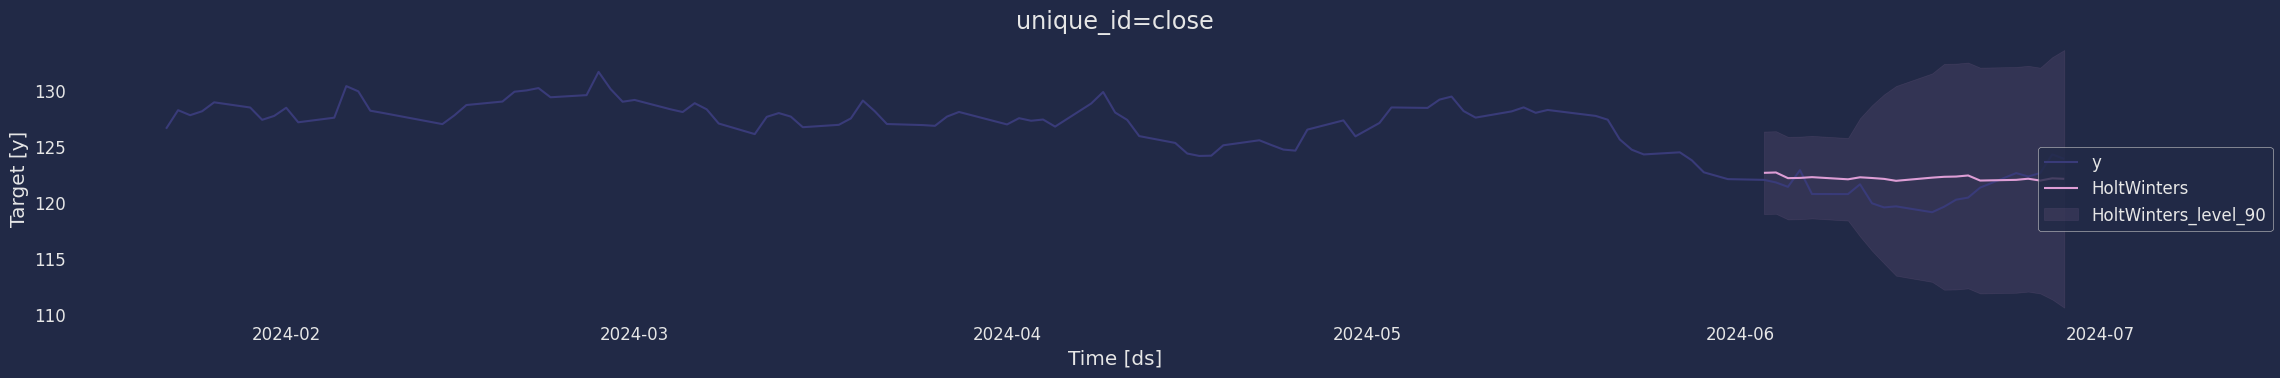

In [124]:
start_model_holt_winters = time.time()
model_holt_winters = StatsForecast(models=[HoltWinters(season_length=12,error_type='M')], freq='B',n_jobs= -1)
model_holt_winters.fit(train[FEATURES])

forecast_dfs = model_holt_winters.predict(h=horizon, level=[90])
forecast_dfs = forecast_dfs.reset_index().merge(test[FEATURES], on=['ds', 'unique_id'], how='left')
forecast_dfs = forecast_dfs.dropna()
end_model_holt_winters = time.time()

y_true = forecast_dfs['y'].values
y_pred = forecast_dfs['HoltWinters'].values

holtwinters_metrics = calculate_metrics(valid=y_true, predicted=y_pred, model="HoltWinters")

total_time_holtwinters = end_model_holt_winters - start_model_holt_winters
print(f"=== Tempo gasto: {total_time_holtwinters}")
model_holt_winters.plot(train[FEATURES], forecast_dfs, level=[90], unique_ids=['close'], engine="matplotlib", max_insample_length=90)

### 3.2. SARIMAX

Entre os vários métodos disponíveis, o modelo SARIMAX (Modelo Autorregressivo Integrado de Médias Móveis Sazonal + variáveis exógenas) se destaca como uma ferramenta poderosa para modelar e prever tendências e variações sazonais em dados temporais, incluindo variáveis externas para melhorar a precisão das previsões. Para entender o SARIMAX, é preciso começar compreendendo o  modelo ARIMA (Autorregressivo Integrado de Médias Móveis). 

O ARIMA é uma técnica estatística eficiente para modelar e prever séries temporais. Ele se baseia em três componentes principais: autorregressão (AR), média móvel (MA) e integração (I).

- `Autorregressão (AR)`: usa os valores passados da série temporal para prever os valores atuais. Geralmente anotada como `p`.
- `Média Móvel (MA)`: lida com erros passados nas previsões e é caracterizada por uma ordem, geralmente anotada como `q`. Ela realiza uma regressão linear sobre os últimos q erros para prever o valor atual.
- `Integração (I)`: usada para tornar a série temporal estacionária, ou seja, para facilitar a modelagem ao diferenciar os valores. Muitas séries temporais podem ser tornadas estacionárias após algumas diferenciações. Geralmente anotada como `d`.

Fonte:  __[SARIMAX model: What is it? How can it be applied to time series?](https://datascientest.com/en/sarimax-model-what-is-it-how-can-it-be-applied-to-time-series)__

Para a construção do modelo SARIMAX, precisamos definir os valores para cada um desses componentes do ARIMA.

Já possuímos o nosso valor `d` graças aos testes de estacionaridade realizados antes. Como nossa série se tornou estacionária com apenas uma diferenciação, `d = 1`. Podemos observar no gráfico abaixo a diferença da série original para a diferenciada, assim como a autocorrelação entre os valores.

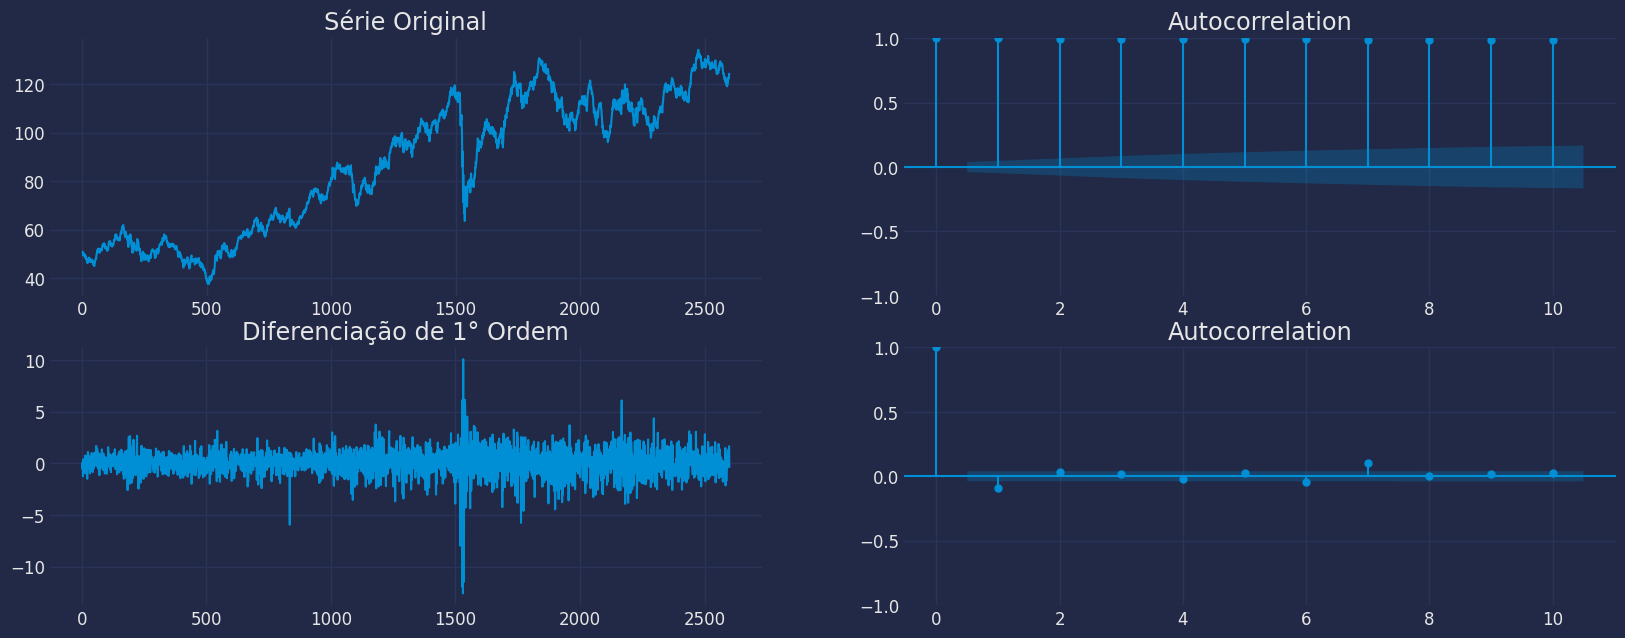

In [125]:
fig, axes = plt.subplots(2, 2, )
axes[0, 0].plot(df_diff["y"]); axes[0, 0].set_title('Série Original')
plot_acf(df_diff["y"], ax=axes[0, 1],lags=10)

axes[1, 0].plot(df_diff["y"].diff()); axes[1, 0].set_title('Diferenciação de 1° Ordem')
plot_acf(df_diff["y"].diff().dropna(), ax=axes[1, 1],lags=10)

plt.show()

Para o valor de AR, podemos achá-lo inspecionando o gráfico de Autocorrelação Parcial (PACF)! A autocorrelação parcial pode ser vista como a correlação entre a série e seu próprio atraso, depois de excluir as contribuições dos atrasos intermediários. Em outras palavras, a PACF mostra a correlação entre um atraso especificado e a série.

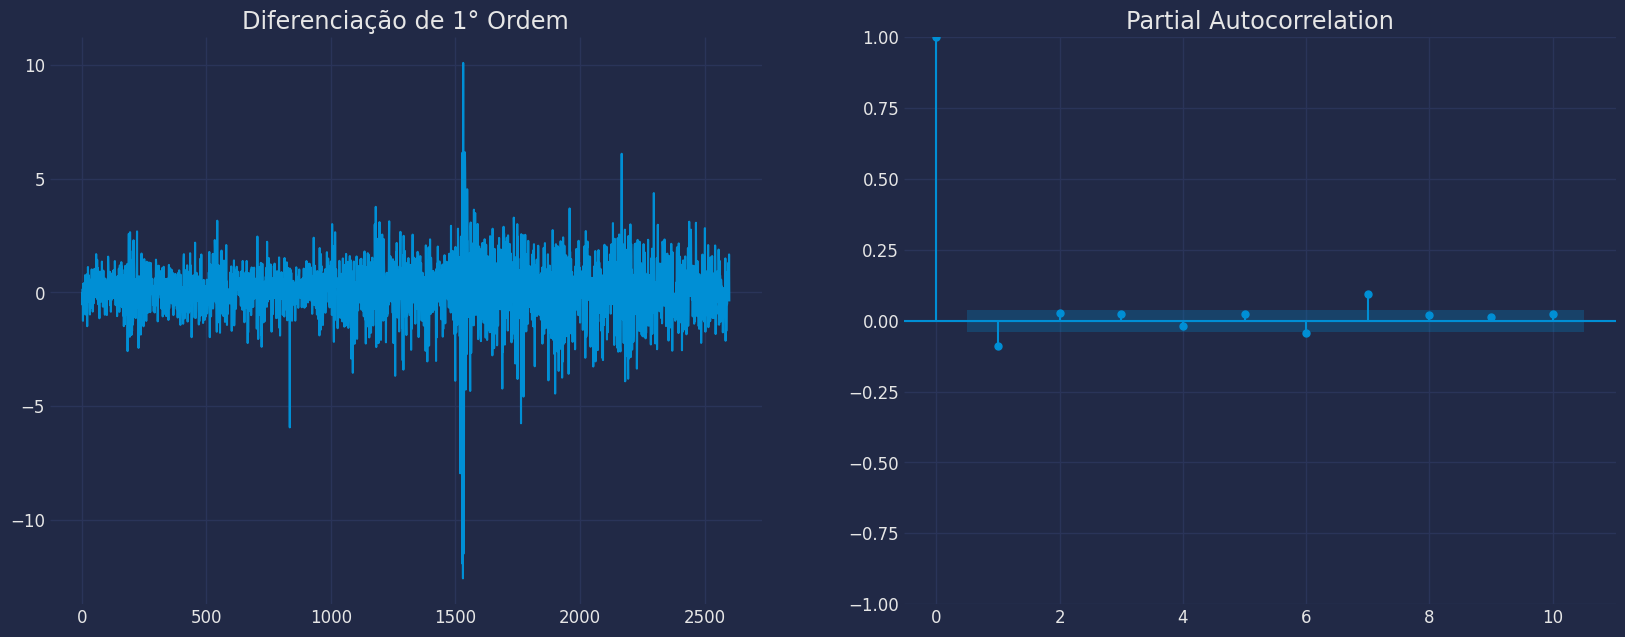

In [126]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(df_diff["y"].diff()); axes[0].set_title('Diferenciação de 1° Ordem')
axes[1].set(ylim=(0,5))
plot_pacf(df_diff["y"].diff().dropna(), ax=axes[1],lags=10)

plt.show()

Tomamos como valor do termo AR o número de traços que ultrapassaram o limite de significância no gráfico do PACF. Neste caso, podemos ver que dois ultrapassaram. Então, temos `p = 2`.

Para este modelo, adicionamos também uma variável externa!

A variável `open`, que se refere ao valor de abertura da ação, é adicionada ao modelo para auxiliar na precisão da previsão.

In [127]:
exog_train = train[['open']]
exog_test = test[['open']]

In [128]:
start_model_sarimax = time.time()
model_sarimax = statsmodelapi.tsa.statespace.SARIMAX(
    endog=train["y"], 
    exog=exog_train, 
    order=(2, 1, 1), 
    seasonal_order=(2, 1, 1, 12)
)
results = model_sarimax.fit()
forecast_predictions = results.get_forecast(steps=len(test), exog=exog_test).predicted_mean
end_model_sarimax = time.time()

y_true = test["y"]
y_pred = forecast_predictions

total_time_sarimax = end_model_sarimax - start_model_sarimax
sarimax_metrics = calculate_metrics(valid=y_true, predicted=y_pred, model="SARIMAX")
print(f"=== Tempo gasto: {total_time_sarimax}")

/home/jessimoura/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/home/jessimoura/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.81341D+00    |proj g|=  2.18716D-01


 This problem is unconstrained.



At iterate    5    f=  1.70616D+00    |proj g|=  6.80877D-02

At iterate   10    f=  1.67895D+00    |proj g|=  3.33444D-02

At iterate   15    f=  1.67498D+00    |proj g|=  8.41656D-03

At iterate   20    f=  1.67437D+00    |proj g|=  9.75066D-04

At iterate   25    f=  1.67403D+00    |proj g|=  9.28615D-03

At iterate   30    f=  1.67352D+00    |proj g|=  1.84781D-02

At iterate   35    f=  1.67317D+00    |proj g|=  6.09299D-03

At iterate   40    f=  1.67305D+00    |proj g|=  5.14313D-03

At iterate   45    f=  1.67304D+00    |proj g|=  1.61847D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     45     55   

Adicionamos os valores preditos à base de teste, na coluna de título `yhat`

In [129]:
test['yhat'] = forecast_predictions

E por fim, podemos gerar o gráfico para visualizar o comportamento dos dados preditos em comparação com os reais!

In [130]:
model_plot(shown_train, test,'SARIMAX')

### 3.3. Prophet

O Prophet é especialmente útil para previsões de negócios e se tornou popular por ser fácil de usar e eficaz com diferentes tipos de dados temporais. Além disso, o Prophet tem recursos úteis, como ajustar a sazonalidade antes e depois da COVID ou tratar bloqueios como feriados pontuais. Ele é um modelo de regressão não linear que também permite ser treinado com outras variáveis além da variável alvo. 

Fonte:  __[Getting Started Predicting Time Series Data with Facebook Prophet](https://towardsdatascience.com/getting-started-predicting-time-series-data-with-facebook-prophet-c74ad3040525)__

Para o modelo `Prophet`, precisamos apenas das colunas de data (`ds`) e valores alvo (`y`).

In [131]:
df_prophet = ibovespa_dataframe[['ds','y']]
df_prophet

,ds,y
0,2014-01-02,50.341
1,2014-01-03,50.981
2,2014-01-06,50.974
3,2014-01-07,50.430
4,2014-01-08,50.577
...,...,...
2595,2024-06-24,122.637
2596,2024-06-25,122.331
2597,2024-06-26,122.641
2598,2024-06-27,124.308


Neste caso, assim como fizemos no SARIMAX, trazemos a variável `open` para contribuir com o treinamento do modelo para a previsão dos dados de fechamento.

In [132]:
train_prophet = train[['ds','y','open']]
test_prophet = test[['ds','y','open']]

start_model_prophet = time.time()
model = Prophet(daily_seasonality=True)
model.add_regressor("open")
model.fit(train_prophet)

future = model.make_future_dataframe(periods=len(test),freq='B')
future["open"] = pd.concat([train["open"], test["open"]], ignore_index=True)
forecast = model.predict(future)
end_model_prophet = time.time()

predictions = forecast[["ds", "yhat"]].tail(len(test))
forecast_prophet = predictions.merge(test_prophet, how='left')
forecast_prophet = forecast_prophet.dropna()

y_true = forecast_prophet['y']
y_pred = forecast_prophet["yhat"]

total_time_prophet = end_model_prophet - start_model_prophet
prophet_metrics = calculate_metrics(y_true, y_pred, 'Prophet')
print(f"=== Tempo gasto: {total_time_prophet}")

00:23:58 - cmdstanpy - INFO - Chain [1] start processing
00:23:59 - cmdstanpy - INFO - Chain [1] done processing


------------- Modelo Prophet -------------
-> MAPE: 0.582%
-> MAE: 0.7061732493387055
-> MSE: 0.8779462489121916
-> R2: 0.5747719347676334
=== Tempo gasto: 1.8844974040985107


Podemos comparar os resultados no gráfico abaixo:

In [133]:
model_plot(shown_train, forecast_prophet,'Prophet')

## 4. Resultados

Juntandos todos os valores armazenados das métricas por modelo:

In [134]:
models_metrics = pd.DataFrame(
    [holtwinters_metrics, sarimax_metrics, prophet_metrics],
    columns=["MAPE", "MAE", "MSE", "R2"],
    index=["HoltWinters", "SARIMAX", "Prophet"],
)

models_time = pd.DataFrame(
    [total_time_holtwinters,total_time_sarimax,total_time_prophet],
    columns=["TIME"],
    index=["HoltWinters", "SARIMAX", "Prophet"],
)

Por meio dessa tabela podemos ter uma visão geral de como os modelos se saíram!

In [135]:
models_metrics

,MAPE,MAE,MSE,R2
HoltWinters,0.012106,1.469085,2.872354,-0.391208
SARIMAX,0.005615,0.681390,0.864916,0.581083
Prophet,0.005819,0.706173,0.877946,0.574772


E o tempo que cada um levou, respectivamente, para o treino e a previsão dos dados:

In [136]:
models_time

,TIME
HoltWinters,0.652976
SARIMAX,93.970832
Prophet,1.884497


### 4.1. Escolha do modelo

De acordo com as métricas apresentadas, pudemos tomar uma decisão sobre qual modelo utilizar para a previsão diária dos valores de fechamento:

O modelo escolhido foi o `Prophet`!

O modelo SARIMAX apresentou valores satisfatórios para as métricas que mais nos interessavam para o contexto de estudo. Entretanto, seu tempo de execução foi entre 5 a 10 vezes maior que o do modelo Prophet, cujos valores das métricas se aproximou bastante dos valores do SARIMAX. Pensando em custo computacional, o tempo gasto de segundos pode não ter alto impacto no contexto apresentado - mas pode ser mais custoso dependendo da quantidade de dados a ser analisada. Por esta razão, acabamos escolhendo o modelo com métricas satisfatórias e com baixo custo computacional.